<a href="https://colab.research.google.com/github/vedvkandge2000/Deep-Learning-Project/blob/master/Image_Captioning_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy==1.1.0

In [2]:
import os
import numpy as np
import h5py
import json
import torch
from PIL import Image
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [13]:
# Function to save checkpoints.
def save_checkpoint(epoch, encoder, decoder, decoder_optimizer):

  state = {
      'epochs': epoch,
      'encoder': encoder,
      'decoder': decoder,
      'decoder_optimizer': decoder_optimizer
  }
  filename = '/content/drive/My Drive/Checkpoints/checkpoint' + str(epoch) + '.pth'
  torch.save(state,filename)

# Calculate avarage.
class Avaragemeter(object):
  def __init__(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0
  
  def update(self, val, n = 1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count
  
 
def adjust_learning_rate(optimizer, shrink_factor):
  optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * shrink_factor
  print("The new learning rate is : {:.3f}".format(optimizer.param_groups[0]['lr']))

In [14]:
# Calculate accuracy of madel (Return top k accuracy)
def accuracy(scores, targets, k):
  """
  scores: batch_size, max(decoding_length),vocab_size --> (sum(decoding_length), vocab_size)
  targets: batch_size, max(decoding_length) --> sum(decoding_length)
  """
  batch_size = targets.size(0)
  _, ind = scores.topk(k, 1)
  correct = ind.eq(targets.view(-1,1).expand_as(ind))
  correct_total = correct.view(-1).float().sum()
  return correct_total * (100 / batch_size)

In [15]:
# This class will load data and getitem function will give return item in data_loader
class Flicker8kDataset(Dataset):

  def __init__(self, data_transform):

    self.h = h5py.File('/content/drive/My Drive/TRAIN_IMAGES.hdf5', 'r')
    self.imgs = self.h['images']
    self.cpi = self.h.attrs['captions_per_image']

    with open('/content/drive/My Drive/TRAIN_CAPTIONS.json', 'r') as j:
      self.captions = json.load(j)

    with open('/content/drive/My Drive/TRAIN_CAPLENS.json', 'r') as f:
      self.caplens = json.load(f)

    self.transform = data_transform

    self.dataset_size = len(self.captions)

  def __getitem__(self, i):
    img = torch.FloatTensor(self.imgs[i // self.cpi] / 255)
    if self.transform is not None:
      img = self.transform(img)

    caption = torch.LongTensor(self.captions[i])

    caplen = torch.LongTensor([self.caplens[i]])

    return img, caption, caplen
  
  def __len__(self):
    return self.dataset_size

In [16]:
# train_loader = torch.utils.data.DataLoader(Flicker8kDataset(data_transform=None),
#                                            batch_size=10,
#                                            shuffle=True,
#                                            pin_memory = True)
# img, caption, caplen = next(iter(train_loader))
# print(img.shape)
# print(caption.shape)
# print(caplen.shape)

In [17]:
# Encoder (Resnet model)
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    resnet = torchvision.models.resnet101(pretrained=True)
    all_modules = list(resnet.children())
    modules = all_modules[:-2] # Remove last classification layer along with pooling layer.
    self.resnet = nn.Sequential(*modules)
    self.avgpool = nn.AvgPool2d(8)
    self.fine_tune()

  def fine_tune(self):
    for p in self.resnet.parameters():
      p.requires_grad = False
  
  def forward(self, images):
    """
    images: (batch_size,3,254,254)
    """
    batch_size = images.shape[0]
    encoded_images = self.resnet(images)
    # encoded_images_size = (batch_size,2048,8,8)
    global_features = self.avgpool(encoded_images).view(batch_size,-1)
    # output_size = (batch_size,2048)
    return global_features 

In [18]:
class Decoder(nn.Module):
  def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim = 2048):
    super(Decoder,self).__init__()
    self.embed_dim = embed_dim
    self.decoder_dim = decoder_dim
    self.vocab_size = vocab_size
    self.encoder_dim = encoder_dim
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    # For each timestep we are giving embeding concatinated with features vector
    self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
    self.fc = nn.Linear(decoder_dim, vocab_size)
    self.init_weights()

  def init_weights(self):
    self.embedding.weight.data.uniform_(-0.1,0.1)
    self.fc.weight.data.uniform_(-0.1,0.1)
    self.fc.bias.data.fill_(0)

  # Since we are passing feature vector to each timestep we have specific hidden state for first tiemstep to zero
  def init_hidden_states(self, batch_size):
    h = torch.zeros(batch_size, self.decoder_dim).to(device)
    c = torch.zeros(batch_size, self.decoder_dim).to(device)
    return h, c

  def forward(self, global_image, encoded_captions, caption_lengths):
    batch_size = global_image.size(0)
    encoder_dim = global_image.size(-1)
    caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending= True)
    global_image = global_image[sort_ind]   
    encoded_captions = encoded_captions[sort_ind]   # (batch_size, max_len)
    embeddings = self.embedding(encoded_captions)  # (batch_size, max_len, emd_dim)
    h,c = self.init_hidden_states(batch_size)
    decode_lengths = (caption_lengths - 1).tolist()
    predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device)

    for t in range(max(decode_lengths)):
      batch_size_t = sum([l > t for l in decode_lengths])
      lstm_input = torch.cat([embeddings[:batch_size_t, t, :], global_image[:batch_size_t]], dim=-1)
      h,c = self.lstm(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
      preds = self.fc(h)
      predictions[:batch_size_t, t, :] = preds
 
    return predictions, encoded_captions, decode_lengths, sort_ind 

In [19]:
# Train function to train the model.
def train(train_loader,encoder,decoder,criterion, decoder_optimizer, epoch):
  encoder.train()
  decoder.train()

  losses = Avaragemeter()
  top3accs = Avaragemeter()

  for i,(image,caption,caplen) in enumerate(train_loader):
    img = image.to(device)
    caption = caption.to(device)
    caplen = caplen.to(device)

    global_features = encoder(img)
    scores, caps_sorted, decode_lengths, sort_ind = decoder(global_features, caption, caplen)
    # Since we decoded starting with <start>, targets are all words after <start> up to <end>
    targets = caps_sorted[:, 1:]

    # Remove timesteps that we didn't decode at, or pad at
    scores = pack_padded_sequence(scores,decode_lengths, batch_first=True)
    targets = pack_padded_sequence(targets,decode_lengths, batch_first=True)
    loss = criterion(scores.data, targets.data)

    # back prop.
    decoder_optimizer.zero_grad()
    loss.backward()
    

    # Clip gradients when they are getting to lagre
    torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, decoder.parameters()), 0.1)

    # Update weights
    decoder_optimizer.step()

    top3 = accuracy(scores.data,targets.data,3)
    losses.update(loss.item(),sum(decode_lengths))
    top3accs.update(top3, sum(decode_lengths))

    if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-3 Accuracy {top3.val:.3f} ({top3.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          loss=losses,
                                                                          top3=top3accs))
 

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim = 512
decoder_dim = 512
decoder_lr = 4e-4
start_epoch = 0
epochs = 28
batch_size = 32
print_freq = 100
checkpoint = '/content/drive/My Drive/Checkpoints/Checkpoints27.pth'
# Read wordmap
with open('/content/drive/My Drive/WORDMAP_flickr8k.json','r') as j:
  word_map = json.load(j)

rev_word_map = {v:k for k,v in word_map.items()}

if checkpoint is None:
  encoder = Encoder()
  decoder = Decoder(embed_dim = emb_dim, decoder_dim = decoder_dim, vocab_size = len(word_map))
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = decoder_lr)
else:
  checkpoint = torch.load(checkpoint)
  start_epoch = checkpoint['epochs'] + 1
  decoder = checkpoint['decoder']
  decoder_optimizer = checkpoint['decoder_optimizer']
  encoder = checkpoint['encoder'] 

encoder  = encoder.to(device)
decoder = decoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform=transforms.Compose([normalize])

train_loader = torch.utils.data.DataLoader(Flicker8kDataset(transform),
                                           batch_size = batch_size,
                                           shuffle = True,
                                           pin_memory=True)

In [35]:
def greedy_decodes(image):
  decoder.eval()
  encoder.eval()
  max_len = 20
  sampled = []
  rev_word_map = {v:k for k,v in word_map.items()} # idx2word
  img = imread(image)
  plt.imshow(img)
  img = imresize(img, (256,256)) # (256,256,3)
  img = img.transpose(2,0,1) # (3,256,256)
  img = img / 255
  img = torch.FloatTensor(img).to(device)

  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  transform=transforms.Compose([normalize])
  image = transform(img)
  # We have unsqueeze image to obtained a image of size (1,3,256,256)
  image = image.unsqueeze(0)

  global_features = encoder(image)
  pred = torch.LongTensor([[word_map['<start>']]]).to(device) # (1,1)
  h,c = decoder.init_hidden_states(1)

  for timestep in range(max_len):
    embeddings = decoder.embedding(pred).squeeze(1) # (1,1,512) --> (1,512)
    lstm_input = torch.cat([embeddings, global_features], dim=-1)  # (1,512) cat (1,512) --> (1, 1024)
    h,c = decoder.lstm(lstm_input, (h, c))  # (1, hidden_size)
    preds = decoder.fc(h)  # (1,vocab_size)
    _, pred =  preds.max(1)
    sampled.append(pred.item())

    if pred == word_map['<end>']:
      break

  generated_words  = [rev_word_map[sampled[i]] for i in range(len(sampled))] 
  filtered_words = " ".join([word for word in generated_words if word!= '<end>'])
  print(filtered_words)

In [ ]:
# Epochs
for epoch in range(start_epoch, epochs):
  
  # Decay learning rate by 0.8 every 3 epochs
  if epoch % 3  == 0 and epoch != 0:
    adjust_learning_rate(decoder_optimizer,0.8)
        
  # One epoch's training
  train(train_loader=train_loader,
        encoder=encoder,
        decoder=decoder,
        criterion=criterion, 
        decoder_optimizer=decoder_optimizer,
        epoch=epoch)
      
  # save checkpoints
  save_checkpoint(epoch, encoder, decoder,decoder_optimizer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


a brown dog is running through the grass


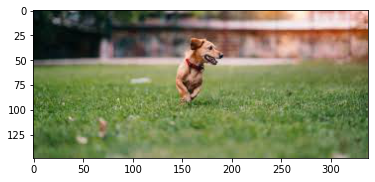

In [36]:
greedy_decodes('/content/drive/My Drive/download.jpg') # Give Image path here.